## Entangled Phase of Simultaneous Fermion and Exciton Condensations Realized
## Published In: *Physical Review B*
## DOI: 
### *LeeAnn M. Sager and David A. Mazziotti*
*Copyright (c) LeeAnn M. Sager and David A. Mazziotti 2022*

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister,execute,Aer,IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.ignis.verification.tomography import count_keys
from qiskit.visualization import plot_histogram
# Importing other necessary libraries, tools, and softwares
from itertools import combinations 
from numpy import linalg as LA
from sympy.physics.quantum import TensorProduct
from scipy.linalg import expm, sinm, cosm
import random
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import numpy as np
import math

In [2]:
# Loading the simulator
beq = Aer.get_backend('qasm_simulator')

In [3]:
# A few useful functions
def tensors(list_of_mats):
    '''
    Returns the matrix resulting from the tensor product of a list of matrices.
    '''
    num_mats = len(list_of_mats)
    tensor_product = list_of_mats[0]
    i=0
    while i+1 < num_mats:
        tensor_product = TensorProduct(tensor_product,list_of_mats[i+1])
        i=i+1
    return tensor_product
def mat_mult(list_of_mats):
    '''
    Returns the matrix resulting from the matrix product of a list of matrices.
    '''
    num_mats = len(list_of_mats)
    product = list_of_mats[0]
    i=0
    while i+1 < num_mats:
        product = np.matmul(product,list_of_mats[i+1])
        i=i+1
    return product
def MatPrint(mat, fmt="g"):
    '''
    Formats and prints matrices/arrays nicely. An upgrade to print(matrix).
    '''
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")
    print("")
def reset(N):
    '''
    Returns a quantum register, a classical register, and a quantum circuit with N qubits.
    '''
    q = QuantumRegister(N)
    c = ClassicalRegister(N)
    qc = QuantumCircuit(q,c)
    return q,c,qc
def get_eight_counts(counts):
    '''Translates the output counts data from the bosonic representation to the fermionic representation
    to allow for the use of the same tomography functions'''
    new_counts={}
    for key in list(counts.keys()):
        new_key=''
        for num in key:
            new_key=new_key+num*2
        new_counts[new_key]=counts[key]
    return new_counts
def get_wavefunction(counts,num_parts=None):
    '''Obtaining the wavefunction corresponding to the counts data.'''
    num_parts=len(list(counts.keys())[0])
    if num_parts == 8:
        pass
    elif num_parts == 4:
        counts=get_eight_counts(counts)
    else:
        return "Error!"
    num_qubits=len(list(counts.keys())[0])
    down = np.array([[1],[0]])
    up = np.array([[0],[1]])
    total=sum(list(counts.values()))
    desired_vector=np.array([[0]*2**(num_qubits)]).T
    for key in counts:
        temp_prob = counts[key]/total
        tensor_list=[]
        for letter in key:
            if letter == '0':
                tensor_list.append(down)
            else:
                tensor_list.append(up)
        desired_vector=desired_vector+np.sqrt(temp_prob)*tensors(list(tensor_list))
    desired_vector[51]=-desired_vector[51]
    desired_vector[60]=-desired_vector[60]
    desired_vector[195]=-desired_vector[195]
    desired_vector[204]=-desired_vector[204]
    return desired_vector

#Defining necessary matrices
cre=np.array([[0,0],[1,0]])
anh=np.array([[0,1],[0,0]])
iden=np.array([[1,0],[0,1]])

## Code for Obtaining $\lambda_D$
#### ${}^{2}D$ Sub-Block Associated with Large Eigenvalue

$$\begin{array}{c|cccc}
                                             &  { \hat{a}_{0}\hat{a}_{1}} &  { \hat{a}_{2}\hat{a}_{3}} & {\cdots}  &  { \hat{a}_{r-2}\hat{a}_{r-1}}\\ \hline
   { \hat{a}_{0}^\dagger\hat{a}^\dagger_{1}} &{ \hat{a}_{0}^\dagger\hat{a}^\dagger_{1}\hat{a}_{0}\hat{a}_{1}}  &{ \hat{a}_{0}^\dagger\hat{a}^\dagger_{1}\hat{a}_{2}\hat{a}_{3}}  &{\cdots}  &{ \hat{a}_{0}^\dagger\hat{a}^\dagger_{1}\hat{a}_{r-2}\hat{a}_{r-1}}  \\
   { \hat{a}_{2}^\dagger\hat{a}^\dagger_{3}} &{ \hat{a}_{2}^\dagger\hat{a}^\dagger_{3}\hat{a}_{0}\hat{a}_{1}}  &{ \hat{a}_{2}^\dagger\hat{a}^\dagger_{3}\hat{a}_{2}\hat{a}_{3}}  &{\cdots}  &{ \hat{a}_{2}^\dagger\hat{a}^\dagger_{3}\hat{a}_{r-2}\hat{a}_{r-1}}  \\
   {\vdots}                                  &{\vdots}  &{\vdots}  &{\ddots}  &{\vdots}  \\
   { \hat{a}_{r-2}^\dagger\hat{a}^\dagger_{r-1}} &{ \hat{a}_{r-2}^\dagger\hat{a}^\dagger_{r-1}\hat{a}_{0}\hat{a}_{1}}  &{ \hat{a}_{r-2}^\dagger\hat{a}^\dagger_{r-1}\hat{a}_{2}\hat{a}_{3}}  &{\cdots}  &{ \hat{a}_{r-2}^\dagger\hat{a}^\dagger_{r-1}\hat{a}_{r-2}\hat{a}_{r-1}}  \\
\end{array}$$

In [4]:
def wfm_D2_on_diag_value(counts,pair_num,num_qubits,num_parts=None,qubits=None):
    N=num_qubits
    i=pair_num*2
    j=i+1
    tensor_list=[]
    for qubit in list(range(int(N))):
        if qubit in [i,j]:
            tensor_list.append(np.matmul(cre,anh))
        else:
            tensor_list.append(iden)
    matrix=tensors(tensor_list)
    psi=get_wavefunction(counts,num_parts)
    temp_value=np.matmul(psi.T,matrix)
    return_value=np.matmul(temp_value,psi)
    return return_value.real


def wfm_D2_off_diag_value(counts,pair_0,pair_1,num_qubits,num_parts=None,qubits=None):
    N=num_qubits
    i=pair_0*2
    j=i+1
    k=pair_1*2
    l=k+1
    tensor_list=[]
    for qubit in list(range(int(N))):
        if qubit in [i,j]:
            tensor_list.append(cre)
        elif qubit in [k,l]:
            tensor_list.append(anh)
        else:
            tensor_list.append(iden)
    matrix=tensors(tensor_list)
    psi=get_wavefunction(counts,num_parts)
    temp_value=np.matmul(psi.T,matrix)
    return_value=np.matmul(temp_value,psi)
    return return_value.real

def wfm_D2_matrix(counts,num_qubits,num_parts=None,qubits=None):
    N=num_qubits
    if qubits==None:
        qubits=list(range(num_qubits))
    num_pairs = int(N/2)
    #First, we need to create a matrix to assign the values to...
    wfm_mat=np.zeros((num_pairs,num_pairs), dtype=complex)
    #Let's tackle the diagonal blocks first...
    for i in range(num_pairs):
        wfm_mat[i,i]=wfm_D2_on_diag_value(counts,i,num_qubits,num_parts,qubits)
    #Then we need to do the off-diagonal blocks...
    comb=combinations(range(num_pairs),2)
    for pair in list(comb):
        pair=list(pair)
        pair.sort()
        i=pair[0]
        j=pair[1]
        wfm_mat[i,j]=wfm_D2_off_diag_value(counts,i,j,num_qubits,num_parts,qubits)
        wfm_mat[j,i]=wfm_D2_off_diag_value(counts,j,i,num_qubits,num_parts,qubits)
    return wfm_mat.real

def get_lambdaD(counts,num_qubits=8,num_parts=None,qubits=None):
    matrix=wfm_D2_matrix(counts,num_qubits,num_parts=None,qubits=None)
    w,v=LA.eig(matrix)
    return max(w).real

## Code for Obtaining $\lambda_G$
#### ${}^{2}G$ Matrix

$$\begin{array}{c|cccc}
     &  { \hat{a}_{q}^\dagger\hat{a}_{q}} &  { \hat{a}_{q+4}^\dagger\hat{a}_{q}} &  { \hat{a}_{q}^\dagger\hat{a}_{q+4}} &  { \hat{a}_{q+4}^\dagger\hat{a}_{q+4}}\\ \hline
   { \hat{a}_{p}^\dagger\hat{a}_{p}} & {  \hat{a}_{p}^\dagger\hat{a}_{p}\hat{a}_{q}^\dagger\hat{a}_{q}}  &  { \hat{a}_{p}^\dagger\hat{a}_{p}\hat{a}_{q+4}^\dagger\hat{a}_{q}} &  { \hat{a}_{p}^\dagger\hat{a}_{p}\hat{a}_{q}^\dagger\hat{a}_{q+4}} &  { \hat{a}_{p}^\dagger\hat{a}_{p}\hat{a}_{q+4}^\dagger\hat{a}_{q+4}}\\
  {  \hat{a}_{p}^\dagger\hat{a}_{p+4}} &  { \hat{a}_{p}^\dagger\hat{a}_{p+4}\hat{a}_{q}^\dagger\hat{a}_{q}}  &  { \hat{a}_{p}^\dagger\hat{a}_{p+4}\hat{a}_{q+4}^\dagger\hat{a}_{q}} &  { \hat{a}_{p}^\dagger\hat{a}_{p+4}\hat{a}_{q}^\dagger\hat{a}_{q+4}} &  { \hat{a}_{p}^\dagger\hat{a}_{p+4}\hat{a}_{q+4}^\dagger\hat{a}_{q+4}}\\
   { \hat{a}_{p+4}^\dagger\hat{a}_{p}} &  { \hat{a}_{p+4}^\dagger\hat{a}_{p}\hat{a}_{q}^\dagger\hat{a}_{q}}  &  { \hat{a}_{p+4}^\dagger\hat{a}_{p}\hat{a}_{q+4}^\dagger\hat{a}_{q}} &  { \hat{a}_{p+4}^\dagger\hat{a}_{p}\hat{a}_{q}^\dagger\hat{a}_{q+4} }& {  \hat{a}_{p+4}^\dagger\hat{a}_{p}\hat{a}_{q+4}^\dagger\hat{a}_{q+4}}\\
   { \hat{a}_{p+4}^\dagger\hat{a}_{p+4}} &  { \hat{a}_{p+4}^\dagger\hat{a}_{p+4}\hat{a}_{q}^\dagger\hat{a}_{q}}   &  { \hat{a}_{p+4}^\dagger\hat{a}_{p+4}\hat{a}_{q+4}^\dagger\hat{a}_{q}} &  { \hat{a}_{p+4}^\dagger\hat{a}_{p+4}\hat{a}_{q}^\dagger\hat{a}_{q+4}} &  { \hat{a}_{p+4}^\dagger\hat{a}_{p+4}\hat{a}_{q+4}^\dagger\hat{a}_{q+4}}.
\end{array}
$$

$$\begin{array}{|c|c|c|c|}
	\hline
	{\scriptstyle  p=0,q=0} & {\scriptstyle  p=0, q=1} & \cdots & {\scriptstyle  p=0,q=\frac{N}{2}-1} \\\hline
	{ \scriptstyle p=1,q=0} & { \scriptstyle p=1, q=1} &  \cdots & { \scriptstyle p=1,q=\frac{N}{2}-1} \\\hline
	\vdots & \vdots & \ddots & \vdots \\\hline
	{ \scriptstyle p=\frac{N}{2}-1,q=0 }& { \scriptstyle p=\frac{N}{2}-1, q=1} & \cdots &{ \scriptstyle  p=\frac{N}{2}-1,q=\frac{N}{2}-1} \\\hline
	\end{array}$$
    
#### ${}^{2}\tilde{G}$ Matrix Modification
$${}^{1}D_p=\begin{array}{c|cc}
	& {\hat{a}_{p}}& {\hat{a}_{p+4}} \\\hline
	{\hat{a}^\dagger_{p}} & {\hat{a}^\dagger_{p}\hat{a}_{p}} & {\hat{a}^\dagger_{p}\hat{a}_{p+4}} \\
	{\hat{a}^\dagger_{p+4}} & {\hat{a}^\dagger_{p+4}\hat{a}_{p}} & {\hat{a}^\dagger_{p+4}\hat{a}_{p+4}} 
	\end{array}$$
    
$$\begin{array}{c|cccc}
     &  {\hat{a}_{q}^\dagger\hat{a}_{q}} &  {\hat{a}_{q+4}^\dagger\hat{a}_{q}} &  {\hat{a}_{q}^\dagger\hat{a}_{q+4}} &  {\hat{a}_{p+4}^\dagger\hat{a}_{p+4}}\\ \hline
   { \hat{a}_{p}^\dagger\hat{a}_{p}} &  { {}^{1}D_p[0,0]{}^{1}D_q[0,0]} &   { {}^{1}D_p[0,0]{}^{1}D_q[0,1]} &   { {}^{1}D_p[0,0]{}^{1}D_q[1,0]} &  { {}^{1}D_p[0,0]{}^{1}D_q[1,1]} \\
  {  \hat{a}_{p}^\dagger\hat{a}_{p+4}} &  { {}^{1}D_p[0,1]{}^{1}D_q[0,0]} &   { {}^{1}D_p[0,1]{}^{1}D_q[0,1]} &   { {}^{1}D_p[0,1]{}^{1}D_q[1,0]} &  { {}^{1}D_p[0,1]{}^{1}D_q[1,1]}  \\
   { \hat{a}_{p+4}^\dagger\hat{a}_{p}} &  { {}^{1}D_p[1,0]{}^{1}D_q[0,0]} &   { {}^{1}D_p[1,0]{}^{1}D_q[0,1]} &   { {}^{1}D_p[1,0]{}^{1}D_q[1,0]} &  { {}^{1}D_p[1,0]{}^{1}D_q[1,1]} \\
   { \hat{a}_{p+4}^\dagger\hat{a}_{p+4}} &  { {}^{1}D_p[1,1]{}^{1}D_q[0,0]} &   { {}^{1}D_p[1,1]{}^{1}D_q[0,1]} &   { {}^{1}D_p[1,1]{}^{1}D_q[1,0]} &  { {}^{1}D_p[1,1]{}^{1}D_q[1,1]}
\end{array}$$

In [5]:
def wfm_G2_submat(counts,qubit_0,qubit_1,num_qubits,num_parts=None,qubits=None):
    N=num_qubits
    mat_out=np.zeros((4,4), dtype=complex) 
    p=qubit_0
    q=qubit_1
    i_mat=l_mat=cre
    j_mat=k_mat=anh
    index_1=0
    for [i,j] in [[p,p],[p,p+4],[p+4,p],[p+4,p+4]]:
        index_2=0
        for [l,k] in [[q,q],[q+4,q],[q,q+4],[q+4,q+4]]:
            tensor_list=[]
            for qubit in list(range(int(N))):
                tensor_list.append(iden)
            tensor_list[i]=np.matmul(tensor_list[i],i_mat)
            tensor_list[j]=np.matmul(tensor_list[j],j_mat)
            tensor_list[l]=np.matmul(tensor_list[l],l_mat)
            tensor_list[k]=np.matmul(tensor_list[k],k_mat)
            matrix=tensors(tensor_list)
            psi=get_wavefunction(counts,num_parts)
            temp_value=np.matmul(psi.T,matrix)
            mat_out[index_1,index_2]=np.matmul(temp_value,psi)
            index_2=index_2+1
        index_1=index_1+1
    return mat_out.real

def wfm_G2_matrix(counts,num_qubits,num_parts=None,qubits=None):
    N=num_qubits
    if qubits==None:
        qubits=list(range(num_qubits))
    #First, we need to create a matrix to assign the values to...
    wfm_mat=np.zeros((16,16),dtype=complex)
    comb=combinations(range(int(N/2)),2)
    #Diagonal Blocks
    for i in list(range(int(N/2))):
        wfm_mat[4*i:4*(i+1),4*i:4*(i+1)]=wfm_G2_submat(counts,i,i,num_qubits,num_parts,qubits)
    #Off-Diagonal Blocks
    for pair in list(comb):
        i=pair[0]
        k=pair[1]
        #print(i,k)
        wfm_mat[4*i:4*(i+1),4*k:4*(k+1)]=wfm_G2_submat(counts,i,k,num_qubits,num_parts,qubits)
        wfm_mat[4*k:4*(k+1),4*i:4*(i+1)]=wfm_mat[4*i:4*(i+1),4*k:4*(k+1)].T
    return wfm_mat.real

def RDM_q(counts,qubit_num,num_qubits,num_parts=None):
    N=num_qubits
    p=qubit_num
    mat_out=np.zeros((2,2), dtype=complex) 
    psi=get_wavefunction(counts,num_parts)
    index_1=0
    for i in [p,p+4]:
        index_2=0
        for j in [p,p+4]:
            tensor_list=[]
            for qubit in list(range(int(N))):
                tensor_list.append(iden)
            tensor_list[i]=np.matmul(tensor_list[i],cre)
            tensor_list[j]=np.matmul(tensor_list[j],anh)
            matrix=tensors(tensor_list)
            temp_value=np.matmul(psi.T,matrix)
            mat_out[index_1,index_2]=np.matmul(temp_value,psi)
            index_2=index_2+1
        index_1=index_1+1
    return mat_out.real

def block_mod(counts,qubit_0,qubit_1,num_qubits,num_parts=None):
    N=num_qubits
    mod_mat=np.zeros((4,4), dtype=complex) 
    q1=qubit_0
    q2=qubit_1
    RDM_q1=RDM_q(counts,q1,N,num_parts)
    RDM_q2=RDM_q(counts,q2,N,num_parts)
    order_of_values_q1=[RDM_q1[0,0],RDM_q1[0,1],RDM_q1[1,0],RDM_q1[1,1]]
    order_of_values_q2=[RDM_q2[0,0],RDM_q2[0,1],RDM_q2[1,0],RDM_q2[1,1]]
    for i in range(4):
        for j in range(4):
            mod_mat[i,j]=order_of_values_q1[i]*order_of_values_q2[j]
    return mod_mat
    
def wfm_tG2_matrix(counts,num_qubits,num_parts=None,qubits=None):
    N=num_qubits
    if qubits==None:
        qubits=list(range(num_qubits))
    #First, we need to create a matrix to assign the values to...
    wfm_mat=np.zeros((16,16),dtype=complex)
    comb=combinations(range(int(N/2)),2)
    #Diagonal Blocks
    for i in list(range(int(N/2))):
        wfm_mat[4*i:4*(i+1),4*i:4*(i+1)]=wfm_G2_submat(counts,i,i,num_qubits,num_parts,qubits)-block_mod(counts,i,i,num_qubits,num_parts)
    #Off-Diagonal Blocks
    for pair in list(comb):
        i=pair[0]
        k=pair[1]
        #print(i,k)
        wfm_mat[4*i:4*(i+1),4*k:4*(k+1)]=wfm_G2_submat(counts,i,k,num_qubits,num_parts,qubits)-block_mod(counts,i,k,num_qubits,num_parts)
        wfm_mat[4*k:4*(k+1),4*i:4*(i+1)]=wfm_mat[4*i:4*(i+1),4*k:4*(k+1)].T
    return wfm_mat.real

def get_lambdaG(counts,num_qubits=8,num_parts=None,qubits=None):
    matrix=wfm_tG2_matrix(counts,num_qubits,num_parts=None,qubits=None)
    w,v=LA.eig(matrix)
    return max(w).real

# Fermionic Preparation
$$|\Psi\rangle=\alpha|11110000\rangle-\beta|11001100\rangle-\gamma|11000011\rangle-\gamma|00111100\rangle-\beta|00110011\rangle+\alpha|00001111\rangle$$

In [6]:
N=8
def create_qc_8(list_of_angles,N):
    '''Fermionic quantum state preparation that results in the wavefunction given above.'''
    qc=QuantumCircuit(N,N)
    qc.ry(list_of_angles[0],0*2)
    qc.ry(list_of_angles[1],1*2)
    #Phase 1
    qc.cx(0*2,1*2)
    #Phase 2
    qc.cx(0*2,2*2)
    qc.cx(1*2,3*2)
    qc.x(0*2)
    qc.x(1*2)
    #Phase 3
    qc.cx(1*2,0*2)
    qc.ry(-list_of_angles[2],1*2)
    qc.cx(0*2,1*2)
    qc.ry(list_of_angles[2],1*2)
    qc.cx(1*2,0*2)
    #Phase 4
    qc.crz(np.pi,3*2,1*2)
    qc.crz(np.pi,3*2,2*2)
    for pair in range(int(N/2)):
        first=pair*2
        second=first+1
        qc.cx(first,second)
    qc.measure(list(range(N)),list(range(N)))
    return qc

#Example State Preparation
list_of_angles=[np.pi/2,-1.924*np.pi/3,np.pi/9.75]
qc8=create_qc_8(list_of_angles,N)
qc8.draw()

┌─────────┐            ┌───┐     ┌───┐                     »
q_0: ──┤ RY(π/2) ├────■────■──┤ X ├─────┤ X ├──────────────────■──»
       └─────────┘    │    │  └───┘     └─┬─┘                  │  »
q_1: ─────────────────┼────┼──────────────┼────────────────────┼──»
     ┌─────────────┐┌─┴─┐  │       ┌───┐  │  ┌──────────────┐┌─┴─┐»
q_2: ┤ RY(-2.0148) ├┤ X ├──┼────■──┤ X ├──■──┤ RY(-0.32221) ├┤ X ├»
     └─────────────┘└───┘  │    │  └───┘     └──────────────┘└───┘»
q_3: ──────────────────────┼────┼─────────────────────────────────»
                         ┌─┴─┐  │                                 »
q_4: ────────────────────┤ X ├──┼─────────────────────────────────»
                         └───┘  │                                 »
q_5: ───────────────────────────┼─────────────────────────────────»
                              ┌─┴─┐                               »
q_6: ─────────────────────────┤ X ├───────────────────────────────»
                              └───┘                               »
q_7: ─────────────────────────────────────────────────────────────»
                                                                  »
c: 8/═════════════════════════════════════════════════════════════»
                                                                  »
«                    ┌───┐                  ┌─┐                          
«q_0: ───────────────┤ X ├────■─────────────┤M├──────────────────────────
«                    └─┬─┘  ┌─┴─┐           └╥┘┌─┐                       
«q_1: ─────────────────┼────┤ X ├────────────╫─┤M├───────────────────────
«     ┌─────────────┐  │  ┌─┴───┴─┐          ║ └╥┘     ┌─┐               
«q_2: ┤ RY(0.32221) ├──■──┤ RZ(π) ├────■─────╫──╫──────┤M├───────────────
«     └─────────────┘     └───┬───┘  ┌─┴─┐   ║  ║      └╥┘┌─┐            
«q_3: ────────────────────────┼──────┤ X ├───╫──╫───────╫─┤M├────────────
«                             │    ┌─┴───┴─┐ ║  ║       ║ └╥┘┌─┐         
«q_4: ────────────────────────┼────┤ RZ(π) ├─╫──╫───■───╫──╫─┤M├─────────
«                             │    └───┬───┘ ║  ║ ┌─┴─┐ ║  ║ └╥┘┌─┐      
«q_5: ────────────────────────┼────────┼─────╫──╫─┤ X ├─╫──╫──╫─┤M├──────
«                             │        │     ║  ║ └───┘ ║  ║  ║ └╥┘┌─┐   
«q_6: ────────────────────────■────────■─────╫──╫───■───╫──╫──╫──╫─┤M├───
«                                            ║  ║ ┌─┴─┐ ║  ║  ║  ║ └╥┘┌─┐
«q_7: ───────────────────────────────────────╫──╫─┤ X ├─╫──╫──╫──╫──╫─┤M├
«                                            ║  ║ └───┘ ║  ║  ║  ║  ║ └╥┘
«c: 8/═══════════════════════════════════════╩══╩═══════╩══╩══╩══╩══╩══╩═
«                                            0  1       2  3  4  5  6  7

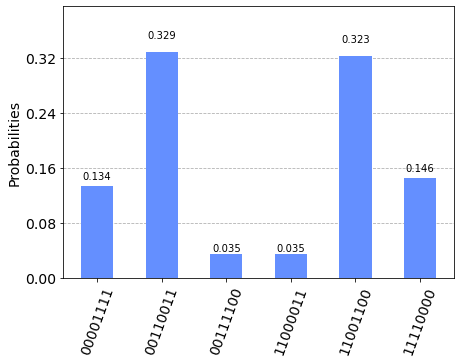

In [7]:
#Histogram plot of the bosonic counts data
results=execute(qc8,beq,shots=8192).result() #getting the results from simulating the circuit
counts=results.get_counts() #obtaining counts data
plot_histogram(counts) #plotting the histogram

In [8]:
#Obtaining the \lambda_D and \lambda_G values for this fermionic state preparation
lambda_D=get_lambdaD(counts)
lambda_G=get_lambdaG(counts)
print("lambda_D",lambda_D)
print("lambda_G",lambda_G)

lambda_D 1.2782906355457504
lambda_G 1.3026657363236422


### Projection Error Mitigation Technique
$$|00001111\rangle=\Psi[15]$$
$$|00110011\rangle=\Psi[51]$$
$$|00111100\rangle=\Psi[60]$$
$$|11000011\rangle=\Psi[195]$$
$$|11001100\rangle=\Psi[204]$$
$$|11110000\rangle=\Psi[240]$$

In [9]:
def cull_counts(counts):
    num_parts=len(list(counts.keys())[0])
    if num_parts == 8:
        pass
    elif num_parts == 4:
        counts=get_eight_counts(counts)
    else:
        return "Error!"
    new_counts={}
    new_counts['00001111']=counts['00001111']
    new_counts['00110011']=counts['00110011']
    new_counts['00111100']=counts['00111100']
    new_counts['11000011']=counts['11000011']
    new_counts['11001100']=counts['11001100']
    new_counts['11110000']=counts['11110000']
    return new_counts

In [10]:
# Getting the \lambda_D and \lambda_G values from this projection technique
culled_counts = cull_counts(counts)
lambda_D=get_lambdaD(culled_counts)
lambda_G=get_lambdaG(culled_counts)
print("lambda_D",lambda_D)
print("lambda_G",lambda_G)

lambda_D 1.2782906355457504
lambda_G 1.3026657363236422


## Bosonic Preparation
$$|\Psi\rangle=\alpha|1100\rangle-\beta|1010\rangle-\gamma|1001\rangle-\gamma|0110\rangle-\beta|0101\rangle+\alpha|0011\rangle$$

In [11]:
N=4
def create_qc_4(list_of_angles,N):
    '''Bosonic quantum state preparation that results in the wavefunction given above.'''
    qc=QuantumCircuit(N,N)
    qc.ry(list_of_angles[0],0)
    qc.ry(list_of_angles[1],1)
    #Phase 1
    qc.cx(0,1)
    #Phase 2
    qc.cx(0,2)
    qc.cx(1,3)
    qc.x(0)
    qc.x(1)
    #Phase 3
    qc.cx(1,0)
    qc.ry(-list_of_angles[2],1)
    qc.cx(0,1)
    qc.ry(list_of_angles[2],1)
    qc.cx(1,0)
    #Phase 4
    qc.crz(np.pi,3,1)
    qc.crz(np.pi,3,2)
    qc.measure(list(range(N)),list(range(N)))
    return qc

#Example State Preparation
list_of_angles=[np.pi/2,-1.924*np.pi/3,np.pi/9.75]
qc4=create_qc_4(list_of_angles,N)
qc4.draw()

┌─────────┐            ┌───┐     ┌───┐                     »
q_0: ──┤ RY(π/2) ├────■────■──┤ X ├─────┤ X ├──────────────────■──»
     ┌─┴─────────┴─┐┌─┴─┐  │  └───┘┌───┐└─┬─┘┌──────────────┐┌─┴─┐»
q_1: ┤ RY(-2.0148) ├┤ X ├──┼────■──┤ X ├──■──┤ RY(-0.32221) ├┤ X ├»
     └─────────────┘└───┘┌─┴─┐  │  └───┘     └──────────────┘└───┘»
q_2: ────────────────────┤ X ├──┼─────────────────────────────────»
                         └───┘┌─┴─┐                               »
q_3: ─────────────────────────┤ X ├───────────────────────────────»
                              └───┘                               »
c: 4/═════════════════════════════════════════════════════════════»
                                                                  »
«                    ┌───┐         ┌─┐                  
«q_0: ───────────────┤ X ├─────────┤M├──────────────────
«     ┌─────────────┐└─┬─┘┌───────┐└╥┘         ┌─┐      
«q_1: ┤ RY(0.32221) ├──■──┤ RZ(π) ├─╫──────────┤M├──────
«     └─────────────┘     └───┬───┘ ║ ┌───────┐└╥┘┌─┐   
«q_2: ────────────────────────┼─────╫─┤ RZ(π) ├─╫─┤M├───
«                             │     ║ └───┬───┘ ║ └╥┘┌─┐
«q_3: ────────────────────────■─────╫─────■─────╫──╫─┤M├
«                                   ║           ║  ║ └╥┘
«c: 4/══════════════════════════════╩═══════════╩══╩══╩═
«                                   0           1  2  3

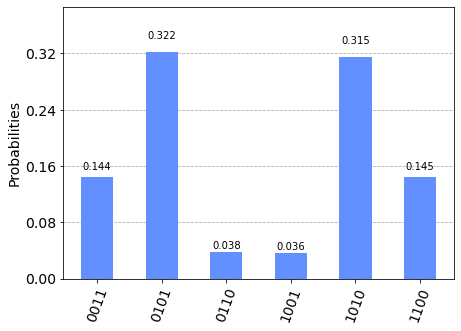

In [12]:
#Histogram plot of the bosonic counts data
results=execute(qc4,beq,shots=8192).result() #getting the results from simulating the circuit
counts=results.get_counts() #obtaining counts data
plot_histogram(counts) #plotting the histogram

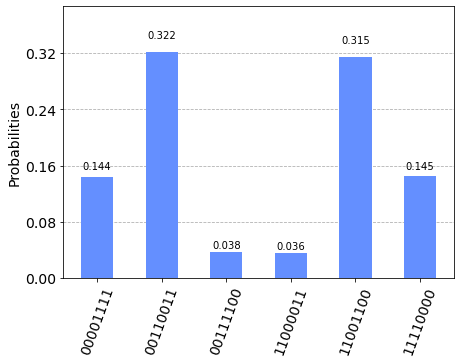

In [13]:
#Fermionic histogram results corresponding to the bosonic results obtained above.
counts_fermionic=get_eight_counts(counts) #convert counts data from bosonic to fermionic representation
plot_histogram(counts_fermionic) #plotting the fermionic histogram

In [14]:
#Obtaining the \lambda_D and \lambda_G values for this bosonic state preparation
lambda_D=get_lambdaD(counts)
lambda_G=get_lambdaG(counts)
print("lambda_D",lambda_D)
print("lambda_G",lambda_G)

lambda_D 1.2926217159573654
lambda_G 1.2735848131536476


### Projection Error Mitigation Technique

In [15]:
# Getting the \lambda_D and \lambda_G values from this projection technique
culled_counts = cull_counts(counts)
lambda_D=get_lambdaD(culled_counts)
lambda_G=get_lambdaG(culled_counts)
print("lambda_D",lambda_D)
print("lambda_G",lambda_G)

lambda_D 1.2926217159573654
lambda_G 1.2735848131536476
